In [1]:
import matplotlib.pyplot as plt
from scipy.special import binom

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import Clifford

from fourier_vqa import *
from tests.test_fourier_vqa import *
from experiments_utils import *

import os
import dill

import networkx as nx

# Plotting

In [2]:
def plot_node_stats(all_node_samples, plot_random=True, num_qubits=-1):
    
    num_samples = len(all_node_samples)
    M = len(all_node_samples[0]) - 1
    
    
    norm_samples = all_node_samples * 2. ** (-np.arange(M + 1))
    normilized_node_samples = all_node_samples/all_node_samples.sum(axis=1, keepdims=True)
    
    node_means = np.mean(normilized_node_samples, axis=0)
    node_variations = np.std(normilized_node_samples, axis=0)
    
    norm_means = np.mean(norm_samples, axis=0)
    norm_variations = np.std(norm_samples, axis=0)
    
    c_node = 'blue'
    c_norm = 'orange'

    plt.plot(range(M + 1), node_means, color=c_node);
    plt.plot(range(M + 1), norm_means, color=c_norm);

    plt.fill_between(range(M + 1), node_means - node_variations, node_means + node_variations, alpha=0.75,
                     color=c_node);
    plt.fill_between(range(M + 1), norm_means - norm_variations, norm_means + norm_variations, alpha=0.75,
                     color=c_norm);
    
    if plot_random:
        plt.plot(range(M + 1), random_node_distribution(M), color=c_node, linestyle='--')
        plt.plot(range(M + 1), random_norm_distribution(M), color=c_norm, linestyle='--')


    plt.title(f'num_qubits={num_qubits}, num_paulis={M}, num_samples={num_samples}')

# Random circuits

## Level statistics for fully random circuits

In [47]:
np.random.seed(0)

num_qubits = 15
num_paulis = 20
num_samples = 4

pauli_seeds = np.random.randint(0, 2**32-1, (num_samples, num_paulis))
observable_seeds = np.random.randint(0, 2**32-1, num_samples)

paulis = [[random_pauli(num_qubits, seed) for seed in seeds_row] for seeds_row in pauli_seeds]
observables = [random_pauli(num_qubits, seed) for seed in observable_seeds]

pauli_circuits = [PauliCircuit(p) for p in paulis]
fourier_computations = [FourierComputation(pauli_circuit, observable) for pauli_circuit, observable in zip(pauli_circuits, observables)]

for fourier_computation in fourier_computations:
    fourier_computation.run(check_admissible=False, verbose=False)

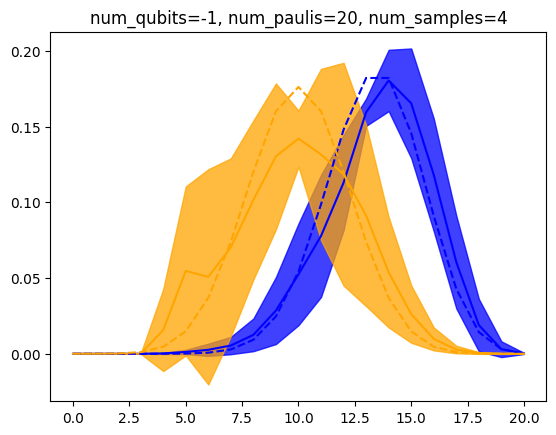

In [48]:
all_node_samples = np.array([fourier_computation.node_stats() for fourier_computation in fourier_computations])    
plot_node_stats(all_node_samples, plot_random=True)

## Level statistics for local circuits with random observables

In [5]:
np.random.seed(1)

num_samples = 20
num_qubits = 10
degree = 2
level = 1

qaoa_seeds = np.random.randint(0, 2**32, num_samples)
observable_seeds = np.random.randint(0, 2**32, num_samples)

graphs = [nx.random_regular_graph(degree, num_qubits, seed=int(seed)) for seed in qaoa_seeds]
qaoa_circuits = [PauliCircuit.from_parameterized_circuit(QAOA(graph, level).circuit()) for graph in graphs]
observables = [random_pauli(num_qubits, seed) for seed in observable_seeds]
fourier_computations = [FourierComputation(circuit, observable) for circuit, observable in zip(qaoa_circuits, observables)]

for fourier_computation in tqdm(fourier_computations):
    fourier_computation.run(check_admissible=False, verbose=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:54<00:00,  2.72s/it]


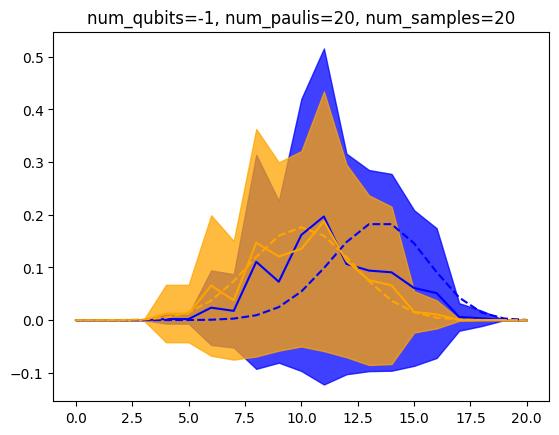

In [7]:
all_node_samples = np.array([fourier_computation.node_stats() for fourier_computation in fourier_computations])    
plot_node_stats(all_node_samples, plot_random=True)

# Hardware-efficient circuits

In [78]:
pqc = local_circuit(50, 300)

pauli_circuit = PauliCircuit.from_parameterized_circuit(pqc)
observable = Pauli('XX'+'I'*(pqc.num_qubits-2))

fourier_computation = FourierComputation(pauli_circuit, observable)
fourier_computation.run(check_admissible=False)

  7%|███▉                                                      | 27/400 [44:20<10:12:31, 98.53s/it, (relative: 89.17%, absolute: 0.06, remaining: 0.0073)]


KeyboardInterrupt: 

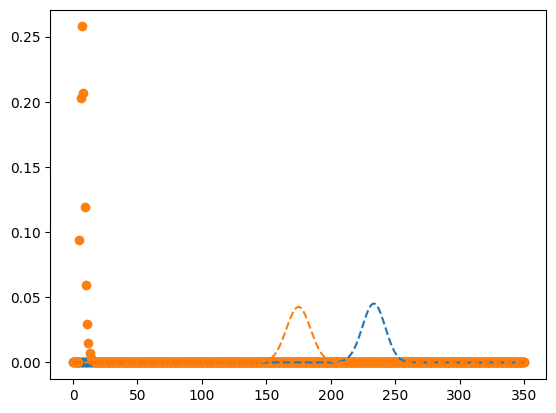

In [60]:
fourier_computation.visualize()

# QAOA

In [3]:
num_qubits = 20
degree = 2
level = 2


graph = nx.random_regular_graph(degree, num_qubits, seed=41)
qaoa = QAOA(graph, level)

qc = qaoa.circuit()
observables = qaoa.observables()

pauli_circuit = PauliCircuit.from_parameterized_circuit(qc)

print(len(pauli_circuit.paulis))
print(len(observables))

for observable in observables[:5]:
    fourier_computation = FourierComputation(pauli_circuit, observable)
    fourier_computation.run(check_admissible=False)
    exact_nodes = len(fourier_computation.complete_nodes)
    est_nodes = fourier_computation.estimate_node_count(num_samples=1000)
    print(f'exact {exact_nodes} estimated {est_nodes} percentage {est_nodes/exact_nodes:2%}')

80
20


 24%|████████████████▍                                                    | 19/80 [00:04<00:14,  4.10it/s, (relative: 100.00%, absolute: 0, remaining: 0)]


exact 4489 estimated 4698.736 percentage 104.672221%


  9%|█████▊                                                             | 7/80 [00:00<00:02, 32.59it/s, (relative: 100.00%, absolute: 0.12, remaining: 0)]


exact 166 estimated 164.27200000000002 percentage 98.959036%


 24%|████████████████▍                                                    | 19/80 [00:04<00:15,  3.83it/s, (relative: 100.00%, absolute: 0, remaining: 0)]


exact 4489 estimated 4778.608 percentage 106.451504%


 24%|████████████████▍                                                    | 19/80 [00:04<00:14,  4.20it/s, (relative: 100.00%, absolute: 0, remaining: 0)]


exact 4489 estimated 4408.432 percentage 98.205213%


 24%|██████████████▉                                                | 19/80 [00:04<00:15,  4.01it/s, (relative: 100.00%, absolute: 0.00042, remaining: 0)]


exact 4489 estimated 4162.672 percentage 92.730497%


In [ ]:
num_qubits = 30
degree = 3
level = 2


graph = nx.random_regular_graph(degree, num_qubits, seed=41)
qaoa = QAOA(graph, level)

qc = qaoa.circuit()
observables = qaoa.observables()

pauli_circuit = PauliCircuit.from_parameterized_circuit(qc)

print(f'num paulis {pauli_circuit.num_paulis}')
# pauli_circuit.paulis = pauli_circuit.paulis[num_qubits:]

fourier_computation = FourierComputation(pauli_circuit, observables[2])

for observable in observables[:5]:
    fourier_computation = FourierComputation(pauli_circuit, observable)
    print(f'{fourier_computation.estimate_node_count(num_samples=1000):.3e}')

num paulis 150
4.492e+05


In [ ]:
%%prun -s tot
fourier_computation.run(check_admissible=True)

Example.

## Pushing N to the limit

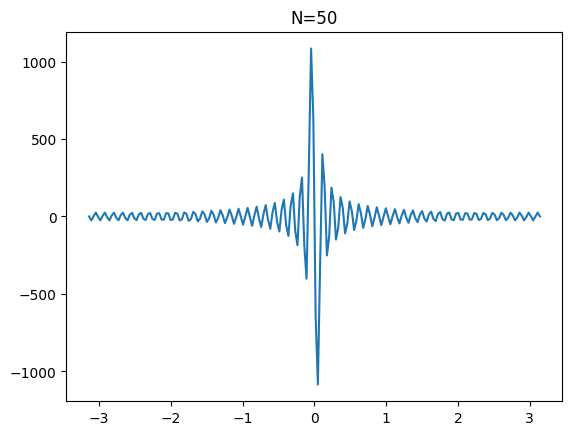

In [38]:
x = np.linspace(-np.pi, np.pi, 200)

def vals(N):
    return -sum([np.cos(n*x) for n in range(N+1)])

def grads(N):
    return -sum([n*np.sin(n*x) for n in range(N+1)])

# for N in [1, 4, 10, 30]:
N=50
plt.plot(x, grads(N))
plt.title(f'N={N}')
plt.savefig(f'results/N={N}.png')